# Gutenberg-Richter Analysis

In [1]:
#!/usr/bin/env python
import math
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import scoreatpercentile
from matplotlib.dates import date2num
import seaborn as sns

from obspy import UTCDateTime
from obspy.signal.filter import lowpass as obspy_lowpass
from obspy import read_events

In [2]:
def estimate_b_value(magnitude_histogram, bin_edges):
    """
    Calculate maximum likelihood b-value of assumed Gutenberg-Richter power law
    frequency-magnitude distribution on binned magnitude data.

    :type magnitude_histogram: :class:`numpy.ndarray`
    :param magnitude_histogram: Input magnitude histogram counts as output by
        :func:`numpy.histogram()`.
    :type bin_edges: :class:`numpy.ndarray`
    :param bin_edges: Bin edges of magnitude binning as output by
        :func:`numpy.histogram()`.
    :rtype: float
    """
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    mean_magnitude = (
        (magnitude_histogram * bin_centers).sum() / magnitude_histogram.sum())
    # Utsu 1966 uses first bin center as threshold magnitude and then corrects
    # by subtracting half the bin width. This is equal to simply using the
    # first left bin edge as threshold magnitude right away.
    minimum_magnitude = bin_edges[0]
    b_value = math.log10(math.e) / (mean_magnitude - minimum_magnitude)
    return b_value

In [3]:
def estimate_b_values(magnitude_histogram, bin_edges):
    """
    Calculate array of b-values, in turn taking each bin center as a starting
    point.

    :type magnitude_histogram: :class:`numpy.ndarray`
    :param magnitude_histogram: Input magnitude histogram counts as output by
        :func:`numpy.histogram()`.
    :type bin_edges: :class:`numpy.ndarray`
    :param bin_edges: Bin edges of magnitude binning as output by
        :func:`numpy.histogram()`.
    :return: 2-tuple of left-most magnitude bin centers used for b value
        estimation and corresponding b values. Both arrays are shorter than
        input histogram by one element because no b-value can be computed for
        only the last magnitude bin.
    :rtype: 2-tuple of :class:`numpy.ndarray`
    """
    bin_centers = (bin_edges[:-2] + bin_edges[1:-1]) / 2.0
    magnitude_thresholds = bin_centers
    b_values = np.empty_like(magnitude_thresholds)
    for i in range(len(magnitude_thresholds)):
        b_values[i] = estimate_b_value(
            magnitude_histogram[i:], bin_edges[i:])
    return magnitude_thresholds, b_values

In [57]:
def estimate_b_values_smoothed(magnitudes, bin_edges, bin_width=0.02, lowpass=False):
    """
    Calculate smoothed array of b-values for given magnitude set.

    :type magnitudes: :class:`numpy.ndarray`
    :param magnitudes: Input magnitude data for b-value estimation (e.g.
        magnitude data above magnitude of completeness in a catalog).
    :type bin_width: float
    :param bin_width: Spacing of magnitude thresholds for output b-value array.
    :type lowpass: bool
    :param lowpass: Whether or not to apply a second smoothing step with a
        lowpass filter.
    :return: 2-tuple of minimum magnitudes used in b-value calculation and
        corresponding b-values.
    :rtype: 2-tuple of :class:`numpy.ndarray`
    """
    
    magnitudes, b = estimate_b_values(magnitudes, bin_edges)
    
    ## set array of magnitude sample points for output
    magnitudes_ = np.arange(-5, magnitudes.max(), bin_width)
    magnitudes_ = magnitudes_[magnitudes_ > magnitudes.min()]
    
    ## first smoothing step: do a linear spline interpolation
    interpolation = interp1d(magnitudes, b, kind="slinear")
    b = interpolation(magnitudes_)
    
    ## second smoothing step: lowpass
    if lowpass:
        b = obspy_lowpass(b, 4, 1.0/bin_width, corners=1, zerophase=True)
        
    return magnitudes_, b

In [64]:
def _extract_magnitudes_and_times(
        catalog, starttime=None, endtime=None, daily_start=None,
        daily_end=None, use_first_pick=True):
    times = []
    magnitudes = []

    for event in catalog:
        # select magnitude, skip if none is found
        mag = event.preferred_magnitude()
        if mag is None:
            if not event.magnitudes:
                print("Event with no magnitude '%s', skipping event." %
                      event.resource_id)
                continue
            mag = event.magnitudes[0]
        if mag.mag is None:
            print("Magnitude with no magnitude value '%s', skipping event." %
                  mag.resource_id)
            continue
        # select origin (or optionally earliest pick) for time
        origin = event.preferred_origin()
        if origin is None:
            if not event.origins:
                if use_first_pick and event.picks:
                    # use earliest pick
                    origin = sorted([pick for pick in event.picks
                                     if pick.time],
                                    key=lambda p: p.time)[0]
                else:
                    print("Event with no origin '%s', skipping event." %
                          event.resource_id)
                    continue
            else:
                origin = event.origins[0]
        if origin.time is None:
            print("Origin with no origin time '%s', skipping event." %
                  origin.resource_id)
            continue
        magnitudes.append(mag.mag)
        times.append(origin.time)

    magnitudes = np.array(magnitudes, dtype=float)
    times = np.array(times, dtype=UTCDateTime)

    # deselect events
    mask = np.full_like(times, True, dtype=bool)
    for i, t in enumerate(times):
        hour_of_day = (t.hour + t.minute / 60.0 +
                       (t.second + t.microsecond * 1e-6) / 3600.0)
        # deselect by time of day
        if daily_start is not None and daily_end is not None:
            if daily_start < daily_end:
                if hour_of_day < daily_start or hour_of_day > daily_end:
                    mask[i] = False
                    continue
            elif daily_end < daily_start:
                if hour_of_day > daily_end and hour_of_day < daily_start:
                    mask[i] = False
                    continue
        elif daily_start is not None:
            if hour_of_day < daily_start:
                mask[i] = False
                continue
        elif daily_end is not None:
            if hour_of_day > daily_end:
                mask[i] = False
                continue
        # deselect by starttime/endtime
        if starttime is not None and t < starttime:
            mask[i] = False
            continue
        if endtime is not None and t > endtime:
            mask[i] = False
            continue
    magnitudes = magnitudes[mask]
    times = times[mask]
    return magnitudes, times

In [65]:
def gutenberg_richter_fit(
        catalog, min_goodness_of_fit=90, bin_width=0.1, min_mag=None,
        max_mag=None, starttime=None, endtime=None, daily_start=0,
        daily_end=24, use_first_pick=True, verbose=False, plot=False,
        show=True, outfile=None, title=None, magnitude_conversion=None):
    """
    Gutenberg-Richter fit and magnitude of completeness estimation by maximum
    likelihood b-value estimation and goodness of fit test after Wiemer and
    Wyss, 2000, BSSA.

    :type success: bool
    :param success: ``True`` if the specified minimum goodness of fit was
        reached and the magnitude of completeness was selected as the first
        magnitude threshold that has a larger goodness of fit, or ``False`` if
        the minimum goodness of fit was never achieved and the magnitude of
        completeness was selected at the first local maximum in the goodness of
        fit curve.
    :param catalog: Catalog with event information.
    :type catalog: :class:`obspy.core.event.Catalog`
    :type plot: bool
    :param plot: Whether to plot results or not.
    :type show: bool
    :param show: Whether to open a Gutenberg-Richter plot.
    :type outfile: str
    :param outfile: Image filename to save a Gutenberg-Richter plot to. Has no
        effect if `plot=False`.
    :type starttime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param starttime: Only consider events after this time.
    :type endtime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param endtime: Only consider events before this time.
    :type daily_start: float
    :param daily_start: Start time of used time window of each day in hours
        (e.g. `9.5` to discard all events from 00:00 to 09:30).
    :type daily_end: float
    :param daily_end: End time of used time window of each day in hours
        (e.g. `21` to discard all events from 21:00 to 24:00).
    :type use_first_pick: bool
    :param use_first_pick: Whether to use time of earliest pick as event time
        stamp if no origin time is present (rather than excluding those
        events).
    :type title: str
    :param title: Title to set on the main Axes, i.e. at the top of the figure
    :type magnitude_conversion: func
    :param magnitude_conversion: Conversion formula for input magnitudes. Can
        be used to convert Ml to Mw with custom formula. The given function
        will be called with the magnitude of each input event as first and only
        argument.
    :rtype: tuple of floats
    :returns: Gutenberg-Richter distribution fit parameters and magnitude of
        completeness (tuple of: success, goodness of fit of returned gutenberg
        richter fit, a-value, b-value, magnitude of completeness,
        total number of events, number of events above Mc).
    """
    magnitudes, times = _extract_magnitudes_and_times(
        catalog=catalog, starttime=starttime, endtime=endtime,
        daily_start=daily_start, daily_end=daily_end,
        use_first_pick=use_first_pick)

    if len(magnitudes) == 0:
        msg = "No events left to process."
        raise Exception(msg)

    times = times
    hist_non_cumul = []
    hist_exceedance = []

    # sorting:
    ind = times.argsort()
    times = times[ind]
    magnitudes = magnitudes[ind]

    min_time = times[0]
    max_time = times[-1]

    # override start/end times?
    min_time = starttime or min_time
    max_time = endtime or max_time

    # restrict to selected time bounds:
    times_bkp = times.copy()
    ind = (times >= min_time) & (times <= max_time)
    magnitudes = magnitudes[ind]
    times = times[ind]

    duration_in_years = (max_time - min_time) / (3600 * 24 * 365)
    if verbose:
        print("%.2f years of data" % duration_in_years)
        print("%.2f years of data till end of catalog" %
              ((times_bkp[-1] - min_time) / (3600 * 24 * 365)))

    if min_mag is None:
        min_mag = min(magnitudes)
    if max_mag is None:
        max_mag = max(magnitudes)
    bin_edges = np.arange(
        min_mag - 0.001, max_mag + bin_width + 0.001, bin_width)
    bin_left_edges = bin_edges[:-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # make histograms,
    # both normal binning as well as exceedance (frequency per year) histogram
    hist_non_cumul, _ = np.histogram(magnitudes, bins=bin_edges)
    hist_exceedance = hist_non_cumul[::-1].cumsum()[::-1]
    hist_exceedance_per_year = hist_exceedance / duration_in_years

    magnitude_thresholds, b_values = estimate_b_values(hist_non_cumul,
                                                       bin_edges)

    goodness_of_fit_all = []
    # for each magnitude threshold (bin), check synthetic fit disregarding bins
    # left of that magnitude bin
    for i, (magnitude_, b_) in enumerate(zip(magnitude_thresholds, b_values)):
        # ignore everything left of current magnitude threshold
        hist_non_cumul_ = hist_non_cumul[i:]
        hist_exceedance_ = hist_exceedance[i:]
        bin_centers_ = bin_centers[i:]

        overall_count_ = hist_non_cumul_.sum()
        a_ = math.log10(overall_count_) + b_ * magnitude_
        synthetic_hist_exceedance = np.array([
            math.pow(10, a_ - b_ * mag_) for mag_ in bin_centers_])

        # compare synthetic with real distribution
        misfits = np.abs(hist_exceedance_ - synthetic_hist_exceedance).sum()
        goodness_of_fit = 100 * (1 - misfits / hist_exceedance_.sum())
        goodness_of_fit_all.append(goodness_of_fit)
        # plt.figure()
        # plt.semilogy(bin_left_edges_, hist_exceedance_, marker="o")
        # plt.semilogy(bin_left_edges_, synthetic_hist_exceedance, marker="o")
        # plt.suptitle(str(goodness_of_fit_all))
        # plt.show()
    goodness_of_fit_all = np.array(goodness_of_fit_all)

    completeness_magnitude = goodness_of_fit_all >= min_goodness_of_fit
    if np.any(completeness_magnitude):
        success = True
        completeness_index = completeness_magnitude.argmax()
    else:
        success = False
        # select first local maximum of goodness of fit curve
        completeness_index = (np.diff(goodness_of_fit_all) < 0).argmax()
    completeness_magnitude = magnitude_thresholds[completeness_index]
    goodness_of_fit = goodness_of_fit_all[completeness_index]
    b_value = b_values[completeness_index]
    a_value = (math.log10(hist_exceedance_per_year[completeness_index]) +
               b_value * completeness_magnitude)
    # plt.figure()
    # plt.plot(bin_left_edges[:len(goodness_of_fit_all)],
    #          100 - goodness_of_fit_all,
    #          marker="o")
    # plt.axvline(completeness_magnitude)
    # plt.axhline(100 - min_goodness_of_fit)
    # plt.xlabel("Magnitude")
    # plt.ylabel("Residual [%]")
    # plt.show()

    # count events >= Mc
    count = (magnitudes >= completeness_magnitude).sum()

    if verbose:
        print("time range: %s -- %s" % (min_time, max_time))
        print("mag min/max/bin_width: %.2f/%.2f/%.2f" % (
            min_mag, max_mag, bin_width))
        print("a-Value: %.2f" % a_value)
        print("b-Value: %.2f" % b_value)
        print("Magnitude of completeness: %.2f" % completeness_magnitude)
        print("%i/%i events >= Mc (%s) in time range %s -- %s" %
              (count, len(magnitudes), completeness_magnitude, min_time,
               max_time))

    if plot or outfile:
        start_index = hist_non_cumul.nonzero()[0][0]
        fig = plt.figure(figsize=(8, 4))
        ax_cumul = fig.add_subplot(111)
        if title:
            ax_cumul.set_title(title)
        fig.subplots_adjust(bottom=0.12)
        ax_noncumul = fig.add_axes([0.6, 0.6, 0.35, 0.32])
        bbox = dict(fc=ax_noncumul.get_facecolor(), ec='None', alpha=0.90)
        synthetic_hist_exceedance = np.power(
            10, a_value - b_value * bin_left_edges)
        ax_noncumul.bar(bin_left_edges, height=hist_non_cumul,
                        width=bin_edges[1:] - bin_edges[:-1], align="edge")
        # ax_noncumul.bar(left=bin_left_edges, height=hist_non_cumul,
        #                 width=bin_edges[1:] - bin_edges[:-1])
        ax_cumul.semilogy(bin_centers[start_index:],
                          hist_exceedance_per_year[start_index:], marker="o",
                          linestyle=" ")
        ax_cumul.semilogy(bin_centers[start_index:],
                          synthetic_hist_exceedance[start_index:], "r-")
        ax_cumul.axvline(completeness_magnitude, color="r")

        info = []
        info.append("Mc  %5.2f" % completeness_magnitude)
        info.append("a   %5.2f" % a_value)
        info.append("b   %5.2f" % b_value)
        info.append("GOF %5.1f" % goodness_of_fit)
        info = "\n".join(info)
        ax_cumul.text(0.03, 0.95, info, color="r", bbox=bbox, ha="left",
                      va="top", family="monospace",
                      transform=ax_cumul.transAxes, zorder=5)
        ax_noncumul.axvline(completeness_magnitude, color="r")

        # plot goodness of fit
        ax_gof = ax_cumul.twinx()
        gof_color = "g"
        ax_gof.plot(bin_centers[start_index:-1],
                    goodness_of_fit_all[start_index:],
                    marker="d", color=gof_color, zorder=-1)
        ax_gof.axhline(min_goodness_of_fit, color=gof_color, zorder=-1)
        ax_gof.set_ylim(0, 100)
        ax_gof.invert_yaxis()
        ax_gof.set_ylabel("Goodness of Fit")
        ax_gof.grid(False)

        ax_noncumul.set_xlabel("magnitude", bbox=bbox)
        ax_cumul.set_xlabel("magnitude")
        ax_noncumul.set_ylabel("absolute count", bbox=bbox)
        ax_cumul.set_ylabel("cumulative count / year")
        time_str = " -- ".join([t.strftime("%Y-%m-%d")
                                for t in (min_time, max_time)])
        fig.suptitle(time_str)

        ax_noncumul.grid(True)
        ax_cumul.grid(True)
        ax_noncumul.set_xlim(*ax_cumul.get_xlim())

        plt.subplots_adjust(top=0.90, right=0.92)
        if outfile:
            plt.savefig(outfile)
            if not plot:
                plt.close(fig)
        if show:
            plt.show()
    return (success, goodness_of_fit, a_value, b_value, completeness_magnitude,
            len(magnitudes), count)

In [70]:
def gutenberg_richter_fit_statistics(catalog, min_goodness_of_fit, bin_widths, num_shifts=4,
        min_mag=None, max_mag=None, starttime=None, endtime=None,
        daily_start=0, daily_end=24, use_first_pick=True, verbose=False,
        plot=False, show=True, outfile=None, save_individual_fits=False):
    """
    Gutenberg-Richter fit and magnitude of completeness estimation 
    after Wiemer and Wyss, 2000, BSSA.
    Gives statistics of results when varying magnitude bin size and offset.
    """
    a = []
    b = []
    mc = []
    if save_individual_fits and outfile:
        magnitudes_, _ = _extract_magnitudes_and_times(
            catalog=catalog, starttime=starttime, endtime=endtime,
            daily_start=daily_start, daily_end=daily_end,
            use_first_pick=use_first_pick)
        x_min = min(magnitudes_)
        x_max = max(magnitudes_)
        dx = x_max - x_min
        x_min -= 0.15 * dx
        x_max += 0.15 * dx
    invalid = 0
    shifts = np.linspace(0, 1, 4, endpoint=False)
    i = 0
    num_individual_fits = len(bin_widths) * len(shifts)
    for bin_width in bin_widths:
        for shift in shifts:
            min_mag = -2.0 + bin_width * shift
            success, _, a_, b_, mc_, count, count_above_mc_ = \
                gutenberg_richter_fit(
                    catalog, min_goodness_of_fit=min_goodness_of_fit,
                    starttime=starttime, endtime=endtime,
                    daily_start=daily_start, daily_end=daily_end,
                    use_first_pick=use_first_pick, bin_width=bin_width,
                    min_mag=min_mag, outfile=None, show=False,
                    plot=save_individual_fits and outfile)
            if save_individual_fits and outfile:
                fig = plt.gcf()
                # make sure all individual plots have same x axis limits
                for ax_ in fig.axes:
                    ax_.set_xlim(x_min, x_max)
                outfile_ = outfile + ".%%0%ii.png"
                outfile_ = outfile_ % len(str(num_individual_fits)) % i
                fig.savefig(outfile_)
                plt.close(fig)
            if not success:
                invalid += 1
            a.append(a_)
            b.append(b_)
            mc.append(mc_)
            i += 1
    if plot or outfile:
        plt.figure(figsize=(7, 7))
        for i, (data, label) in enumerate(zip([a, b, mc], ["a", "b", "Mc"])):
            ax1 = plt.subplot(3, 2, (i*2)+1)
            ax2 = plt.subplot(3, 2, (i*2)+2, sharey=ax1)
            ax1.set_ylabel(label)
            info = ["percentiles\n"]
            # around center: 50%, 68%, 95%
            percentiles = [97.5, 84, 75, 50, 25, 16, 2.5]
            linestyles = ["-", "--", ":", "-", ":", "--", "-"]
            values = np.percentile(data, percentiles)
            for value, percentile, ls in zip(values, percentiles, linestyles):
                ax1.axhline(value, color="k", zorder=1, ls=ls)
                info.append("%6.1f%% %5.2f" % (percentile, value))
            info = "\n".join(info)
            ax2.text(0.98, 0.98, info, color="k", ha="right", va="top",
                     transform=ax2.transAxes)
            sns.violinplot(x=data, orient="v", cut=0, ax=ax1)
            sns.distplot(data, bins=20, vertical=True, kde=False, ax=ax2)
            ax2.set_xlim(right=1.4 * ax2.get_xlim()[1])

        plt.tight_layout()
        if outfile:
            plt.savefig(outfile)
            if not show:
                plt.close()
        if show:
            plt.show()

            return (a, b, mc, count, invalid)

In [ ]:
# def time_dependent_gutenberg_richter_fit(
#         catalog, time_window_length, time_window_step, min_goodness_of_fit=90,
#         starttime=None, endtime=None, daily_start=0, daily_end=24,
#         use_first_pick=True, plot=False, show=True, outfile=None):
#     """
#     Evolution of Gutenberg-Richter fit and magnitude of completeness over time.
# 
#     :param catalog: Catalog with event information (might be changed in
#         place!).
#     :type catalog: :class:`obspy.core.event.Catalog`
#     :type time_window_length: float
#     :param time_window_length: Length of time window for individual
#         Gutenberg-Richter fit (in days).
#     :type time_window_step: float
#     :param time_window_step: Step width of time windows for individual
#         Gutenberg-Richter fits (in days).
#     :type show: bool
#     :param show: Whether to open a Gutenberg-Richter plot.
#     :type outfile: str
#     :param outfile: Image filename to save a Gutenberg-Richter plot to.
#     :type starttime: :class:`obspy.core.utcdatetime.UTCDateTime`
#     :param starttime: Only consider events after this time.
#     :type endtime: :class:`obspy.core.utcdatetime.UTCDateTime`
#     :param endtime: Only consider events before this time.
#     :type daily_start: float
#     :param daily_start: Start time of used time window of each day in hours
#         (e.g. `9.5` to discard all events from 00:00 to 09:30).
#     :type daily_end: float
#     :param daily_end: End time of used time window of each day in hours
#         (e.g. `21` to discard all events from 21:00 to 24:00).
#     :type use_first_pick: bool
#     :param use_first_pick: Whether to use time of earliest pick as event time
#         stamp if no origin time is present (rather than excluding those
#         events).
#     :rtype: tuple of three floats
#     :returns: Gutenberg-Richter distribution fit parameters and magnitude of
#         completeness (tuple of: a-value, b-value, corrected Mc).
#     """
#     # restrict to given start/endtime
#     new_events = []
#     min_time = None
#     max_time = None
#     for event in catalog:
#         # select origin (or earliest pick)
#         origin = event.preferred_origin()
#         if origin is None:
#             if not event.origins:
#                 if use_first_pick and event.picks:
#                     # use earliest pick
#                     origin = sorted([pick for pick in event.picks
#                                      if pick.time],
#                                     key=lambda p: p.time)[0]
#                 else:
#                     print("Event with no origin '%s', skipping event." %
#                           event.resource_id)
#                     continue
#             else:
#                 origin = event.origins[0]
#         time = origin.time
#         if time is None:
#             print("Origin with no origin time '%s', skipping event." %
#                   origin.resource_id)
#             continue
#         if time < starttime or time > endtime:
#             continue
#         new_events.append(event)
#         if min_time is None:
#             min_time = time
#             max_time = time
#         min_time = min(min_time, time)
#         max_time = max(max_time, time)
#     catalog.events = new_events
# 
#     time_window_step_seconds = time_window_step * 24.0 * 3600.0
#     time_window_length_seconds = time_window_length * 24.0 * 3600.0
#     starttimes = np.arange(min_time, max_time + time_window_step_seconds,
#                            time_window_step_seconds, dtype=UTCDateTime)
#     endtimes = starttimes + time_window_length_seconds
# 
#     values = []
#     for i, (start, end) in enumerate(zip(starttimes, endtimes)):
#         try:
#             estimate = gutenberg_richter_fit_statistics(
#                 catalog, min_goodness_of_fit,
#                 plot=False, show=False,
#                 outfile="/tmp/estimate_b_value_statistics_%04i.png" % i,
#                 starttime=start, endtime=end, daily_start=daily_start,
#                 daily_end=daily_end, use_first_pick=use_first_pick)
#         except Exception as e:
#             msg = "Skipping time window (%s)." % str(e)
#             warnings.warn(msg)
#             continue
#         # if estimate[0] == 0 and estimate[1] == 0:
#         #     msg = "Skipping bad estimate with a=b=0.0"
#         #     warnings.warn(msg)
#         #     continue
#         # print(" ".join([str(start.date), str(end.date),
#         #                 "a=%.2f b=%.2f mc=%.1f count_all=%i count_mc=%i" %
#         #                 estimate]))
#         values.append(tuple([start + time_window_step_seconds / 2.0] +
#                             list(estimate)))
# 
#     if plot or outfile:
#         plt.figure()
#         try:
#             x = date2num([val[0].datetime for val in values])
#             ax = None
#             for i, (label, color) in enumerate(zip(["a", "b", "Mc"], "bgr")):
#                 ax = plt.subplot(4, 1, i+1, sharex=ax)
#                 data_median = []
#                 data_5 = []
#                 data_32 = []
#                 data_68 = []
#                 data_95 = []
#                 for value in values:
#                     data = value[i+1]
#                     data_median.append(np.median(data))
#                     data_5.append(scoreatpercentile(data, 5))
#                     data_32.append(scoreatpercentile(data, 32))
#                     data_68.append(scoreatpercentile(data, 68))
#                     data_95.append(scoreatpercentile(data, 95))
#                 plt.plot_date(x, data_median, color=color, ls="-", marker="x")
#                 plt.plot_date(x, data_5, color=color, marker=None, ls=":")
#                 plt.plot_date(x, data_32, color=color, marker=None, ls="--")
#                 plt.plot_date(x, data_68, color=color, marker=None, ls="--")
#                 plt.plot_date(x, data_95, color=color, marker=None, ls=":")
#                 plt.fill_between(x, data_5, data_95, color=color,
#                                  alpha=0.2)
#                 plt.fill_between(x, data_32, data_68, color=color,
#                                  alpha=0.2)
#                 plt.text(0.02, 0.95, label, ha="left", va="top", size="large",
#                          transform=ax.transAxes)
#             ax = plt.subplot(4, 1, 4, sharex=ax)
#             plt.plot_date(x, [v[4] for v in values], "k-")
#             plt.text(0.02, 0.95, "#events", ha="left", va="top", size="large",
#                      transform=ax.transAxes)
#             plt.subplots_adjust(hspace=0.05)
#             plt.tight_layout()
#             if outfile:
#                 plt.savefig(outfile)
#                 if not show:
#                     plt.close()
#             if show:
#                 plt.show()
#         except:
#             plt.close()
#             raise
# 
#     return values

In [8]:
def time_dependent_gutenberg_richter_fit(
        catalog, time_window_length, time_window_step, min_goodness_of_fit=90,
        starttime=None, endtime=None, daily_start=0, daily_end=24,
        use_first_pick=True, plot=False, show=True, outfile=None):
    """
    Evolution of Gutenberg-Richter fit and magnitude of completeness over time.

    :param catalog: Catalog with event information (might be changed in
        place!).
    :type catalog: :class:`obspy.core.event.Catalog`
    :type time_window_length: float
    :param time_window_length: Length of time window for individual
        Gutenberg-Richter fit (in days).
    :type time_window_step: float
    :param time_window_step: Step width of time windows for individual
        Gutenberg-Richter fits (in days).
    :type show: bool
    :param show: Whether to open a Gutenberg-Richter plot.
    :type outfile: str
    :param outfile: Image filename to save a Gutenberg-Richter plot to.
    :type starttime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param starttime: Only consider events after this time.
    :type endtime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param endtime: Only consider events before this time.
    :type daily_start: float
    :param daily_start: Start time of used time window of each day in hours
        (e.g. `9.5` to discard all events from 00:00 to 09:30).
    :type daily_end: float
    :param daily_end: End time of used time window of each day in hours
        (e.g. `21` to discard all events from 21:00 to 24:00).
    :type use_first_pick: bool
    :param use_first_pick: Whether to use time of earliest pick as event time
        stamp if no origin time is present (rather than excluding those
        events).
    :rtype: tuple of three floats
    :returns: Gutenberg-Richter distribution fit parameters and magnitude of
        completeness (tuple of: a-value, b-value, corrected Mc).
    """
    min_time = starttime
    max_time = endtime
    if starttime is None or endtime is None:
        _, times_ = _extract_magnitudes_and_times(
            catalog, use_first_pick=use_first_pick)
        if starttime is None:
            min_time = min(times_)
        if endtime is None:
            max_time = max(times_)
    time_window_step_seconds = time_window_step * 24.0 * 3600.0
    time_window_length_seconds = time_window_length * 24.0 * 3600.0
    starttimes = np.arange(min_time, max_time + time_window_step_seconds,
                           time_window_step_seconds, dtype=UTCDateTime)
    endtimes = starttimes + time_window_length_seconds

    values = []
    print("a_, b_, mc_, count_")
    for i, (start, end) in enumerate(zip(starttimes, endtimes)):
        try:
            (_, _, a_, b_, mc_, count_, _) = gutenberg_richter_fit(
                catalog, min_goodness_of_fit=min_goodness_of_fit,
                plot=False, show=False,
                # outfile="/tmp/estimate_b_value_statistics_%04i.png" % i,
                starttime=start, endtime=end, daily_start=daily_start,
                daily_end=daily_end, use_first_pick=use_first_pick)
            estimate = (a_, b_, mc_, count_)
            print(estimate)
        except Exception as e:
            msg = "Skipping time window (%s)." % str(e)
            warnings.warn(msg)
            continue
        # if estimate[0] == 0 and estimate[1] == 0:
        #     msg = "Skipping bad estimate with a=b=0.0"
        #     warnings.warn(msg)
        #     continue
        # print(" ".join([str(start.date), str(end.date),
        #                 "a=%.2f b=%.2f mc=%.1f count_all=%i count_mc=%i" %
        #                 estimate]))
        values.append(tuple([start + time_window_step_seconds / 2.0] +
                            list(estimate)))
        print(values)

    if plot or outfile:
        plt.figure()
        try:
            x = date2num([val[0].datetime for val in values])
            ax = None
            for i, (label, color) in enumerate(zip(["a", "b", "Mc"], "bgr")):
                ax = plt.subplot(4, 1, i+1, sharex=ax)
                data = [value[i+1] for value in values]
                data_median = data
                plt.plot_date(x, data_median, color=color, ls="-", marker="x")
                plt.text(0.02, 0.95, label, ha="left", va="top", size="large",
                         transform=ax.transAxes)
            ax = plt.subplot(4, 1, 4, sharex=ax)
            plt.plot_date(x, [v[4] for v in values], "k-")
            plt.text(0.02, 0.95, "#events", ha="left", va="top", size="large",
                     transform=ax.transAxes)
            plt.subplots_adjust(hspace=0.05)
            plt.tight_layout()
            if outfile:
                plt.savefig(outfile)
                if not show:
                    plt.close()
            if show:
                plt.show()
        except:
            plt.close()
            raise

    return values

## MAIN

In [21]:
cat = read_events(path_to_catalog, "QUAKEML")

In [24]:
from functions.catalog_to_dataframe import __catalog_to_dataframe

cat_df = __catalog_to_dataframe(cat)

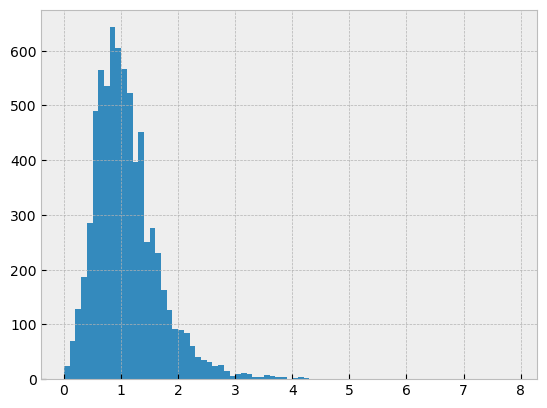

In [43]:
magnitudes = cat_df.magnitude.to_numpy()

bin_width = 0.1
bin_edges = np.arange(0, 8, bin_width)

out = plt.hist(magnitudes, bins=bin_edges)
magnitudes_hist = out[0]

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  


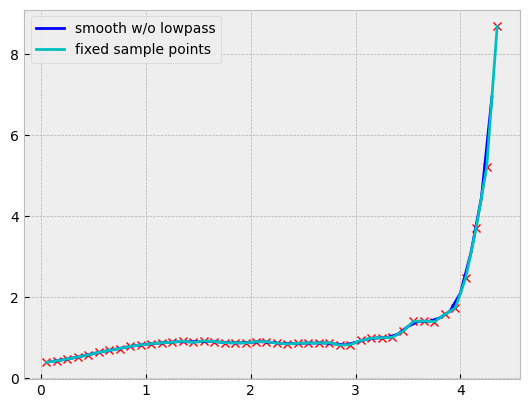

In [72]:
## _________________________________________-
## example for one-off b value estimation

plt.style.use('bmh')
plt.figure()

x, b = estimate_b_values(magnitudes_hist, bin_edges)
plt.plot(x, b, color="r", marker="x", linestyle=" ")

x, b = estimate_b_values_smoothed(magnitudes_hist, bin_edges, bin_width=bin_width, lowpass=False)
plt.plot(x, b, "b-", label="smooth w/o lowpass")

# x, b = estimate_b_values_smoothed(magnitudes_hist, bin_edges, bin_width=bin_width, lowpass=True)
# plt.plot(x, b, "g-", label="smooth w/ lowpass")

x, b = estimate_b_values(magnitudes_hist, bin_edges)
plt.plot(x, b, "c-", label="fixed sample points")

# plt.xlim(-0.8, 1.1)
# plt.ylim(0.7, 1.3)

plt.legend()

plt.show();

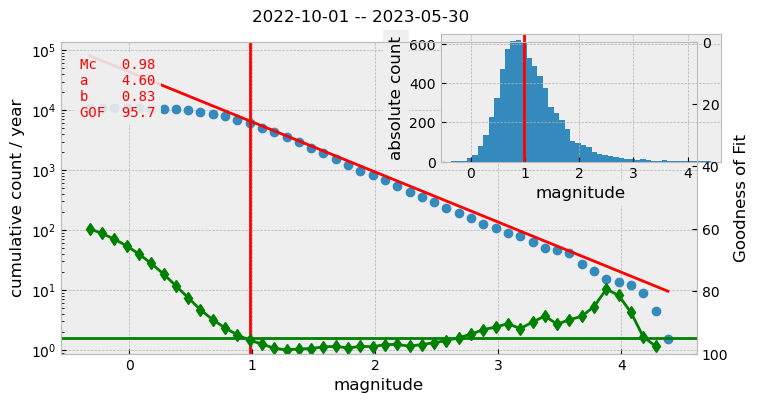

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

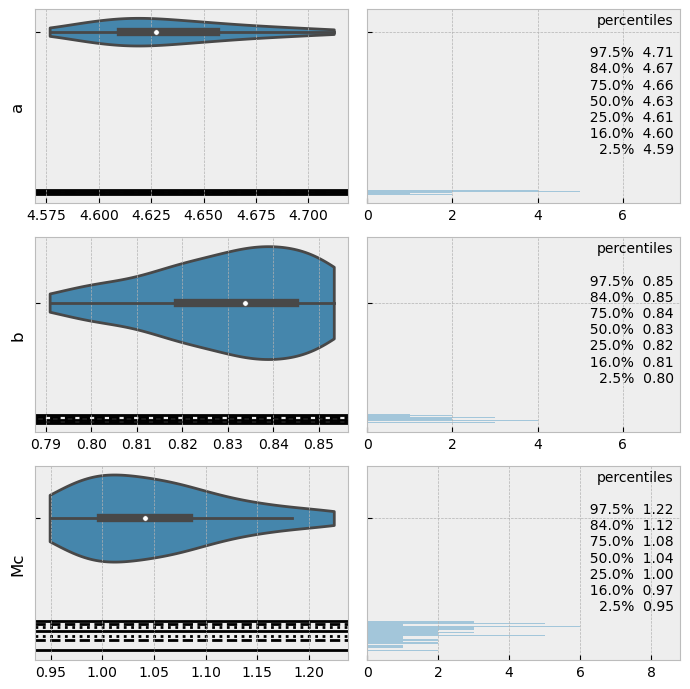

In [71]:
gutenberg_richter_fit(cat, min_goodness_of_fit=95, plot=True, show=True)

gutenberg_richter_fit_statistics(cat, min_goodness_of_fit=95, bin_widths=np.arange(0.1, 0.32, 0.02), 
                                 num_shifts=5, plot=True, show=True)

plt.show()